# ACM GenAI Task2 -- CIFAR-10 dataset Image Classification

In [ ]:
import os
import copy
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
OUTPUT_DIR = Path('./outputs_fastmode')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2
PIN_MEMORY = False

CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2470, 0.2435, 0.2616]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cpu


# Data Preparation & Transforms

In [7]:
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

trainset_noaug = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_no_aug)
trainset_aug = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_aug)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_no_aug)

trainloader_noaug = DataLoader(trainset_noaug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
trainloader_aug = DataLoader(trainset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

classes = trainset_noaug.classes
print('Classes:', classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# TinyVGG CNN (From Scratch)

In [8]:
class TinyVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Helper Functions: Training, Evaluation, Plotting

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)
    return running_loss/total, running_corrects/total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += inputs.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return running_loss/total, running_corrects/total, all_labels, all_preds

def train_model(model, trainloader, testloader, device, epochs=EPOCHS, lr=LEARNING_RATE, wd=WEIGHT_DECAY):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, testloader, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch [{epoch+1}/{epochs}]  Time: {time.time()-t0:.1f}s  TrainLoss: {train_loss:.4f} TrainAcc: {train_acc:.4f}  ValLoss: {val_loss:.4f} ValAcc: {val_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

def plot_history(history, title_prefix, out_path=None):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.title(title_prefix+' Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.title(title_prefix+' Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    if out_path: plt.savefig(out_path)
    plt.show()

def save_confusion_matrix(y_true, y_pred, classes, out_path=None, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.title(title)
    plt.tight_layout()
    if out_path: plt.savefig(out_path)
    plt.show()

def run_experiment(model_fn, trainloader, testloader, exp_name, epochs=EPOCHS, lr=LEARNING_RATE):
    print(f"\n===== Running: {exp_name} =====")
    model = model_fn()
    model, history = train_model(model, trainloader, testloader, DEVICE, epochs=epochs, lr=lr)
    val_loss, val_acc, y_true, y_pred = evaluate(model, testloader, nn.CrossEntropyLoss(), DEVICE)
    print(f'Final Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}')
    plot_history(history, exp_name+' Training', out_path=OUTPUT_DIR/f'{exp_name}_history.png')
    save_confusion_matrix(y_true, y_pred, classes, out_path=OUTPUT_DIR/f'{exp_name}_cm.png', title=exp_name+' Confusion Matrix')
    return {'model': model, 'history': history, 'val_loss': val_loss, 'val_acc': val_acc,
            'cm_path': str(OUTPUT_DIR/f'{exp_name}_cm.png'), 'history_path': str(OUTPUT_DIR/f'{exp_name}_history.png')}

# Runing All Experiments


===== Running: tinyvgg_noaug =====
Epoch [1/4]  Time: 94.3s  TrainLoss: 1.6186 TrainAcc: 0.3991  ValLoss: 1.2441 ValAcc: 0.5578
Epoch [2/4]  Time: 107.5s  TrainLoss: 1.1829 TrainAcc: 0.5757  ValLoss: 0.9733 ValAcc: 0.6544
Epoch [3/4]  Time: 331.4s  TrainLoss: 0.9801 TrainAcc: 0.6553  ValLoss: 0.8850 ValAcc: 0.6871
Epoch [4/4]  Time: 344.6s  TrainLoss: 0.8507 TrainAcc: 0.7038  ValLoss: 0.7527 ValAcc: 0.7445
Final Val Loss: 0.7527  Val Acc: 0.7445


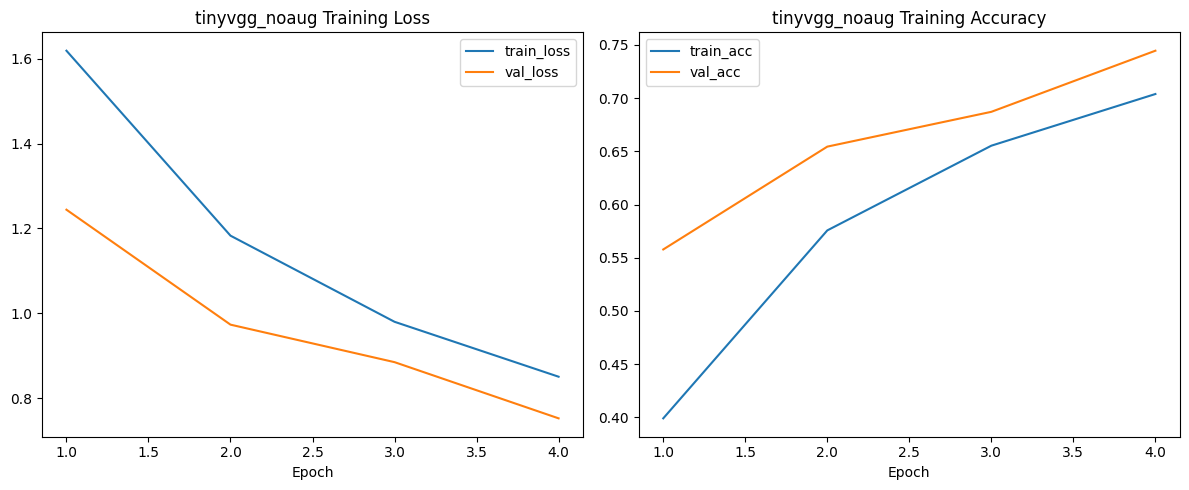

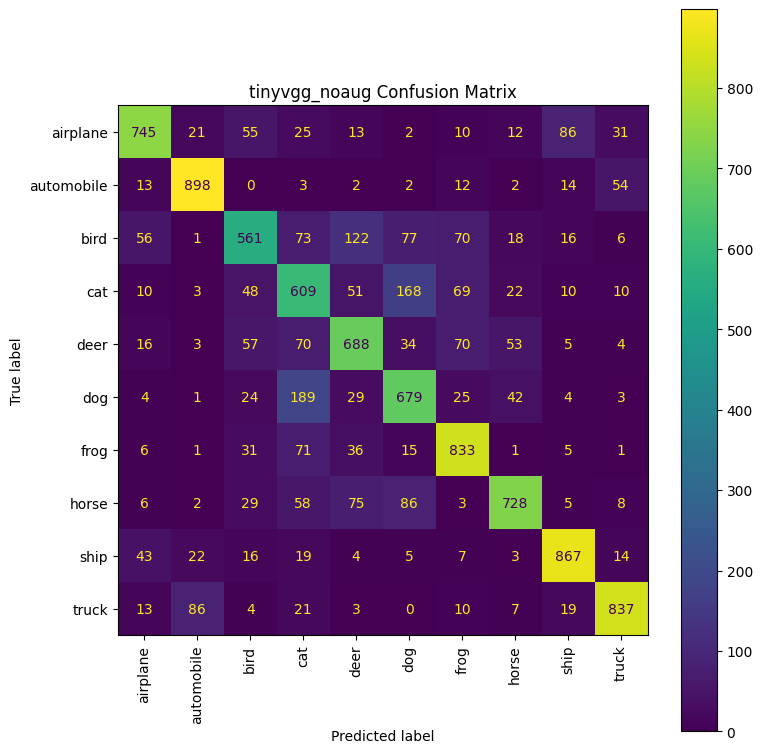


===== Running: tinyvgg_aug =====
Epoch [1/4]  Time: 88.2s  TrainLoss: 1.6738 TrainAcc: 0.3757  ValLoss: 1.3431 ValAcc: 0.5054
Epoch [2/4]  Time: 110.6s  TrainLoss: 1.2994 TrainAcc: 0.5280  ValLoss: 1.1142 ValAcc: 0.5974
Epoch [3/4]  Time: 433.9s  TrainLoss: 1.1273 TrainAcc: 0.5982  ValLoss: 1.0000 ValAcc: 0.6488
Epoch [4/4]  Time: 455.3s  TrainLoss: 1.0119 TrainAcc: 0.6438  ValLoss: 0.8924 ValAcc: 0.6837
Final Val Loss: 0.8924  Val Acc: 0.6837


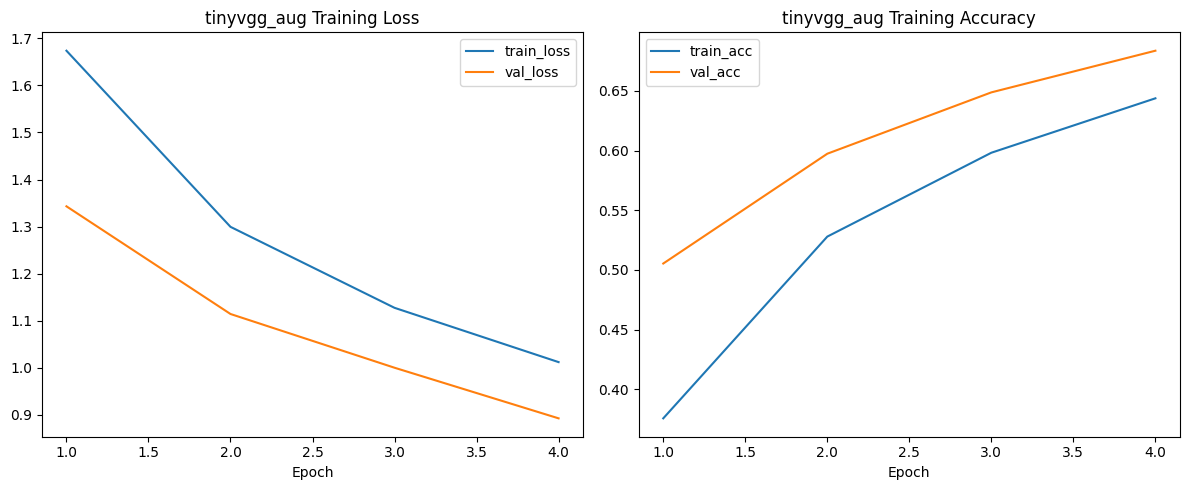

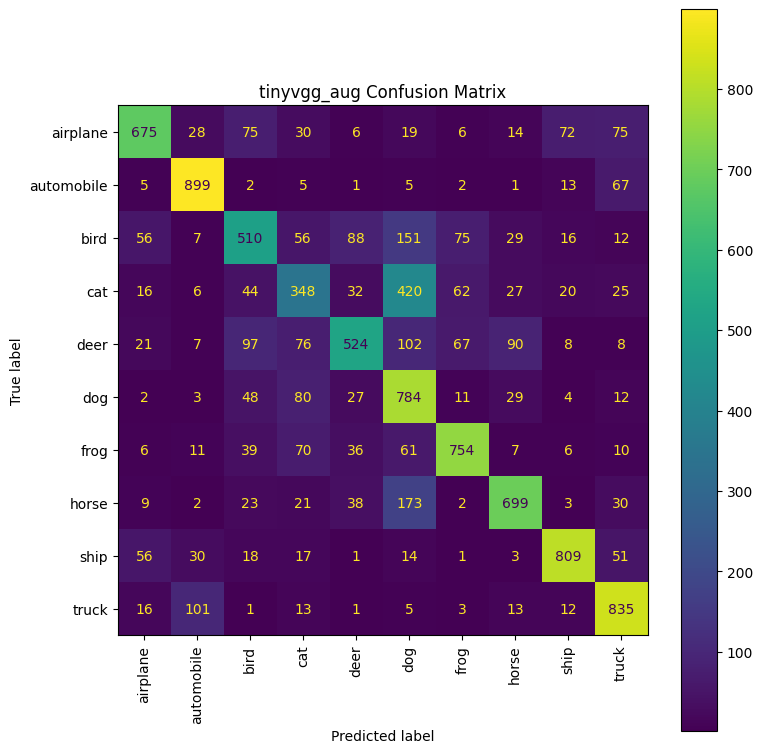


===== Running: resnet_noaug =====


C:\Users\Akash\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Akash\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/4]  Time: 323.9s  TrainLoss: 0.9960 TrainAcc: 0.6561  ValLoss: 0.6708 ValAcc: 0.7716
Epoch [2/4]  Time: 347.0s  TrainLoss: 0.5704 TrainAcc: 0.8037  ValLoss: 0.5981 ValAcc: 0.7980
Epoch [3/4]  Time: 382.0s  TrainLoss: 0.4040 TrainAcc: 0.8599  ValLoss: 0.5783 ValAcc: 0.8077
Epoch [4/4]  Time: 362.2s  TrainLoss: 0.2923 TrainAcc: 0.8984  ValLoss: 0.5866 ValAcc: 0.8144
Final Val Loss: 0.5866  Val Acc: 0.8144


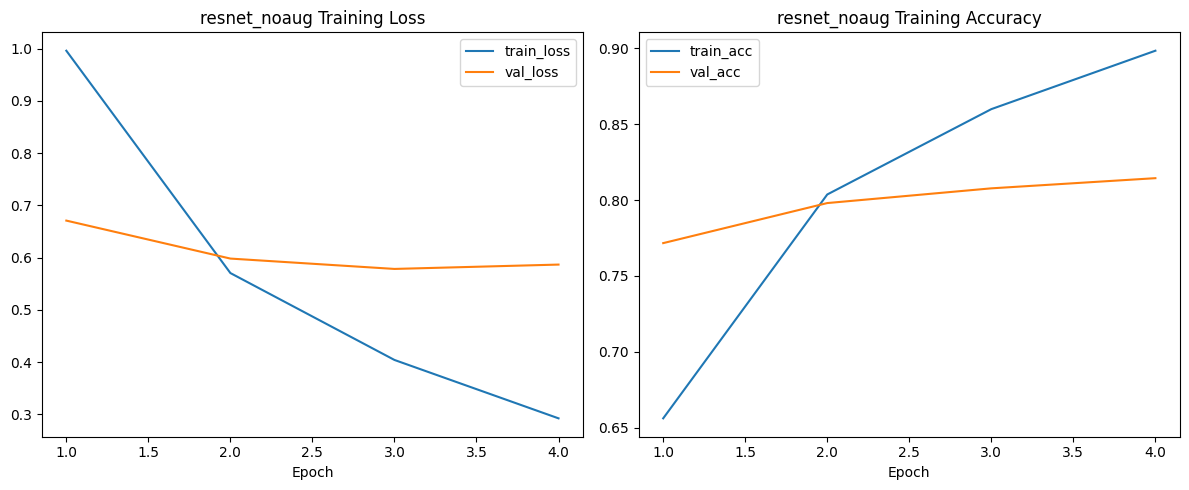

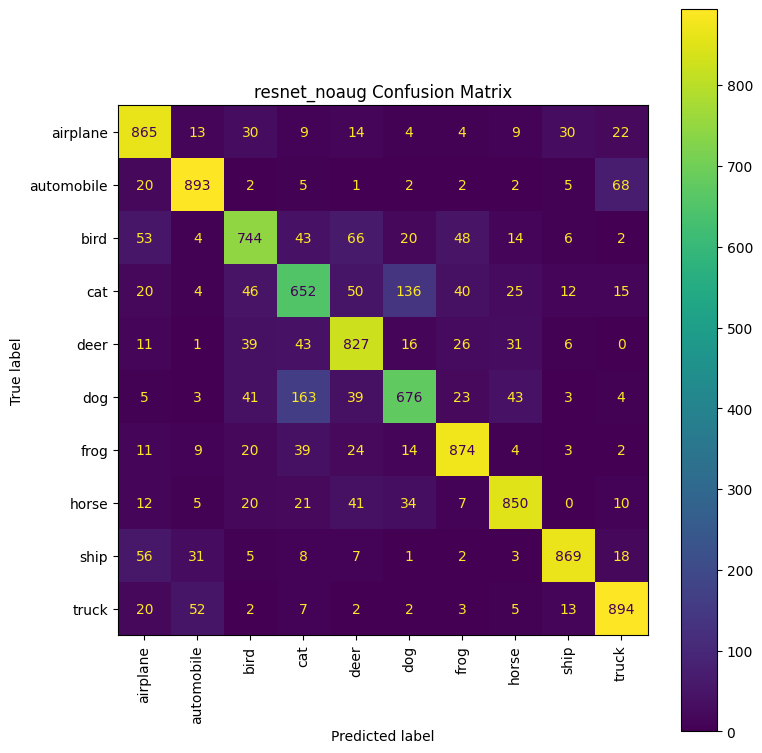


===== Running: resnet_aug =====


C:\Users\Akash\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Akash\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/4]  Time: 318.7s  TrainLoss: 1.1460 TrainAcc: 0.5995  ValLoss: 0.7483 ValAcc: 0.7418
Epoch [2/4]  Time: 382.8s  TrainLoss: 0.7641 TrainAcc: 0.7361  ValLoss: 0.6257 ValAcc: 0.7864
Epoch [3/4]  Time: 429.2s  TrainLoss: 0.6499 TrainAcc: 0.7751  ValLoss: 0.5704 ValAcc: 0.8045
Epoch [4/4]  Time: 406.4s  TrainLoss: 0.5839 TrainAcc: 0.7981  ValLoss: 0.5375 ValAcc: 0.8154
Final Val Loss: 0.5375  Val Acc: 0.8154


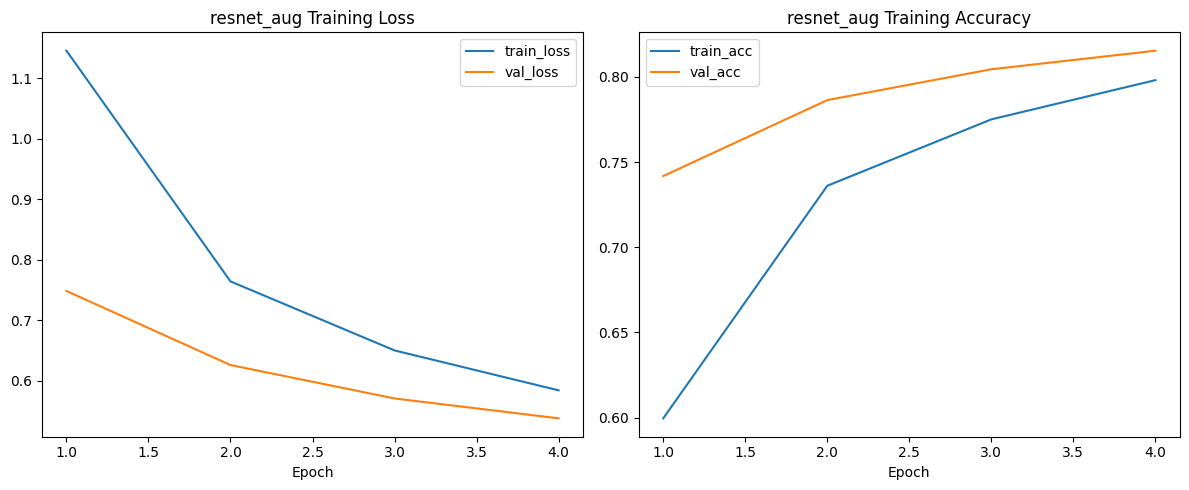

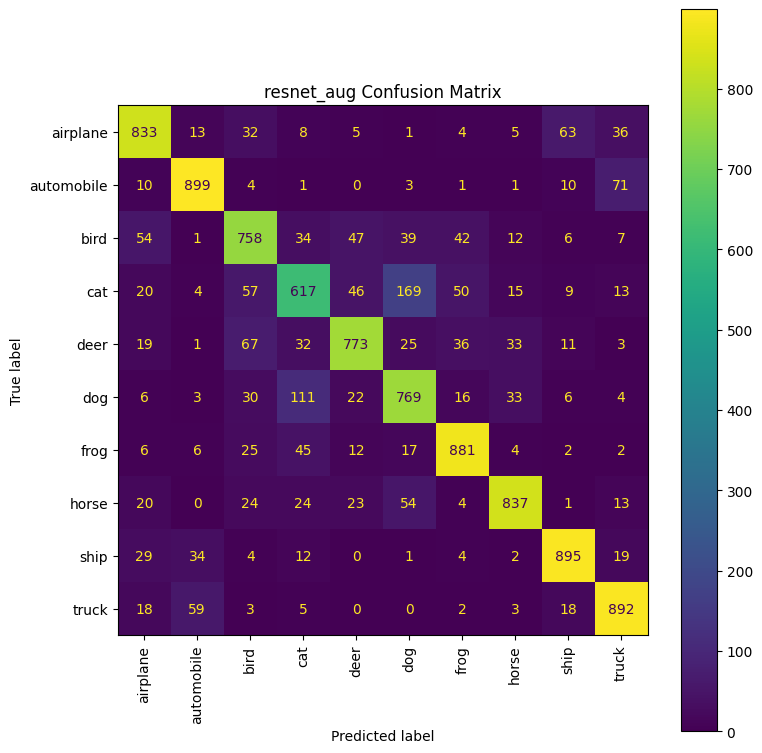

In [10]:
results = {}

results['tinyvgg_noaug'] = run_experiment(lambda: TinyVGG(NUM_CLASSES), trainloader_noaug, testloader, 'tinyvgg_noaug')
results['tinyvgg_aug'] = run_experiment(lambda: TinyVGG(NUM_CLASSES), trainloader_aug, testloader, 'tinyvgg_aug')

def get_resnet(num_classes=NUM_CLASSES):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

results['resnet_noaug'] = run_experiment(get_resnet, trainloader_noaug, testloader, 'resnet_noaug', epochs=EPOCHS, lr=1e-4)
results['resnet_aug'] = run_experiment(get_resnet, trainloader_aug, testloader, 'resnet_aug', epochs=EPOCHS, lr=1e-4)

# Summary Table & CSV

In [11]:
import pandas as pd
summary = []
for k, v in results.items():
    summary.append([k, v['val_loss'], v['val_acc'], v['cm_path'], v['history_path']])
summary_df = pd.DataFrame(summary, columns=['Experiment', 'ValLoss', 'ValAcc', 'ConfusionMatrix', 'HistoryPlot'])
summary_df.to_csv(OUTPUT_DIR/'summary_results.csv', index=False)
print('\n===== Summary Table =====')
print(summary_df)


===== Summary Table =====
      Experiment   ValLoss  ValAcc                        ConfusionMatrix  \
0  tinyvgg_noaug  0.752654  0.7445  outputs_fastmode\tinyvgg_noaug_cm.png   
1    tinyvgg_aug  0.892393  0.6837    outputs_fastmode\tinyvgg_aug_cm.png   
2   resnet_noaug  0.586601  0.8144   outputs_fastmode\resnet_noaug_cm.png   
3     resnet_aug  0.537525  0.8154     outputs_fastmode\resnet_aug_cm.png   

                                  HistoryPlot  
0  outputs_fastmode\tinyvgg_noaug_history.png  
1    outputs_fastmode\tinyvgg_aug_history.png  
2   outputs_fastmode\resnet_noaug_history.png  
3     outputs_fastmode\resnet_aug_history.png  
